### Project: Finding Donors for *CharityML*

## Getting Started

In this project, we will employ several supervised algorithms of our choice to accurately model individuals' income using data collected from the 1994 U.S. Census. we will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. our goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. we can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data

In [2]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, we will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.



In [3]:

#  : Total number of records
n_records = len(data)

#  : Number of records where individual's income is more than $50,000
n_greater_50k = len(data[(data.income == '>50K')])

#  : Number of records where individual's income is at most $50,000
n_at_most_50k = len(data[(data.income == '<=50K')])

#  : Percentage of individuals whose income is more than $50,000
greater_percent = (float(n_greater_50k)/float(n_records))*100

# Print the results
print "Total number of records: {}".format(n_records)
print "Individuals making more than $50,000: {}".format(n_greater_50k)
print "Individuals making at most $50,000: {}".format(n_at_most_50k)
print "Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent)


Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

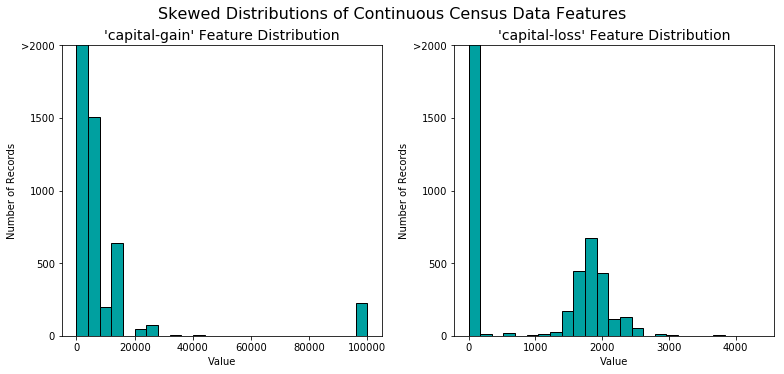

In [4]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

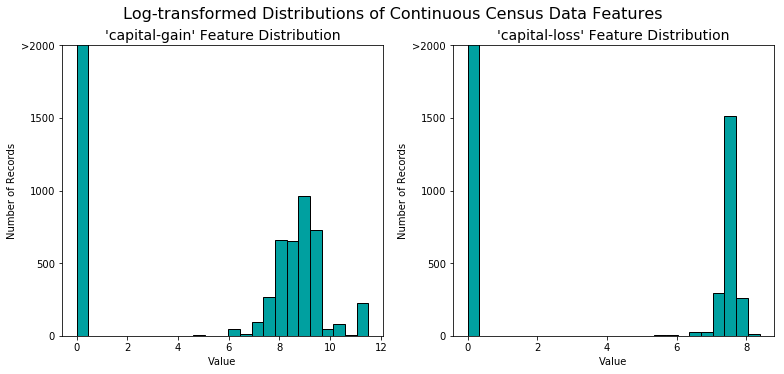

In [5]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_raw[skewed] = data[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_raw, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

In [6]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
features_raw[numerical] = scaler.fit_transform(data[numerical])

# Show an example of a record with scaling applied
display(features_raw.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.00000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.00000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.00000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.00000,0.0,0.397959,Cuba


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, we will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_raw'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [7]:
#  : One-hot encode the 'features_raw' data using pandas.get_dummies()
features = pd.get_dummies(features_raw)

#  : Encode the 'income_raw' data to numerical values
income = income_raw.apply(lambda x: 1 if x == '>50K' else 0)

# Print the number of features after one-hot encoding
encoded = list(features.columns)
print "{} total features after one-hot encoding.".format(len(encoded))

# Uncomment the following line to see the encoded feature names
print encoded

103 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ A

### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

In [8]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, income, test_size = 0.2, random_state = 0)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of our choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for our data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 

### Discussion 1 - Naive Predictor Performace
*If we chose a model that always predicted an individual made more than \$50,000, what would that model's accuracy and F-score be on this dataset?*  
**Note:** we must use the code cell below and assign our results to `'accuracy'` and `'fscore'` to be used later.

In [9]:
#  : Calculate accuracy
accuracy = greater_percent / 100.00

#  : Calculate F-score using the formula above for beta = 0.5
beta = 0.5
recall = 1.0
fscore = (1 + beta**2) * ((accuracy * recall) / (beta**2 * accuracy + recall))


# Print the results and Response for Discussion 1 
print "Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore)

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models
**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that we may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Discussion 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that we will test on the census data. For each model chosen
- *Describe one real-world application in industry where the model can be applied.* (we may need to do research for this — give references!)
- *What are the strengths of the model; when does it perform well?*
- *What are the weaknesses of the model; when does it perform poorly?*
- *What makes this model a good candidate for the problem, given what we know about the data?*

 Response:  
 
 Model | Real-world application | Strength | Weakness | Why it's a good candidate
--- | --- | --- | --- | ---
[Logistic Regression](https://en.wikipedia.org/wiki/Logistic_regression#Fields_and_example_applications) | Medical field for disease diagonsis, marketing field(Like if customer will purchase product or not),mortage/credit card default | It's simple, fast, efficient for small dataset with limited features | it cannot capture complex relationship in data, need fine tune of feature population and selection to avoid underfitting or overfitting | It's the baseline algorithm in most framework; it's widely used in applications
[Support Vector Machine](https://en.wikipedia.org/wiki/Support_vector_machine#Applications) | Text categorization, image classification and hand-written recognition | It has various kernel functions to create non-linear decision boundaries and capture complex relationships in dataset  | It's problematic for learning with huge data points and many features; computational inefficiency; requires complex parameters such as C (regularization) and kernels | it's quite good  in capturing complex relationships in data automatically; it can be optimized by fine tuning parameters
[Decision Tree Classifier](https://en.wikipedia.org/wiki/Decision_tree_learning) | Used in wide variety of fields like Finance(Credit approval),Agriculture(Like high/low yield),Medicine(Disease daignosis) | It is easy & fast to train on large datasets, captures non linear relationships well | Prone to overfitting,a small change in the training data can result in a big change in the tree, and thus a big change in final predictions  | It can provide good accuracy by capturing complex relationships and train in reasonable amount of time

**references**
- [`sklearn`: Choosing the right estimator from](http://scikit-learn.org/stable/tutorial/machine_learning_map/)
- [`sklearn`: Classifier comparison](http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)
- [wikipedia](wikipedia.org)





### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model we've chosen, it's important that we create a training and predicting pipeline that allows we to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. our implementation here will be used in the following section.
In the code block below, we will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that we set the `beta` parameter!

In [10]:
#  : Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score
# time.time() return time in seconds since the Epoch
from time import time

beta = 0.5

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
   
    
    
    #  : Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    #  : Calculate the training time
    results['train_time'] = end - start
        
    #  : Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    #  : Calculate the total prediction time
    results['pred_time'] =end - start
            
    #  : Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    #  : Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    #  : Compute F-score on the the first 300 training samples
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta=beta)
        
    #  : Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=beta)
       
    # Success
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation

LogisticRegression trained on 361 samples.
LogisticRegression trained on 3617 samples.
LogisticRegression trained on 36177 samples.
LinearSVC trained on 361 samples.
LinearSVC trained on 3617 samples.
LinearSVC trained on 36177 samples.
DecisionTreeClassifier trained on 361 samples.
DecisionTreeClassifier trained on 3617 samples.
DecisionTreeClassifier trained on 36177 samples.


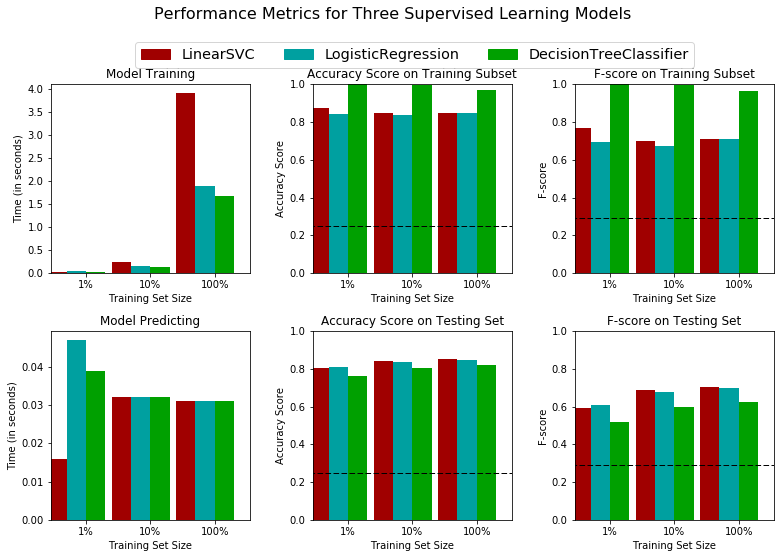

In [13]:
#  : Import the three supervised learning models from sklearn
#  : Import the three supervised learning models from sklearn
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

#  : Initialize the three models
clf_A = LogisticRegression(random_state=101)
clf_B = LinearSVC(random_state=101)
clf_C = DecisionTreeClassifier(random_state=101)

#  : Calculate the number of samples for 1%, 10%, and 100% of the training data
n_train = len(y_train)
samples_1 = int(n_train * 0.01)
samples_10 = int(n_train * 0.1)
samples_100 = n_train

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)


# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)


----
## Improving Results
In this final section, we will choose from the three supervised learning models the *best* model to use on the student data. we will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Discussion 3 - Choosing the Best Model
*Based on the evaluation we performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models we believe to be most appropriate for the task of identifying individuals that make more than \$50,000.*  
**Hint:** our Response should include discussion of the metrics, prediction/training time, and the algorithm's suitability for the data.

**Response: 

A) We are considering three classifiers namely Support Vector Machine, Logistic Regression and Decision Tree for prediction purpose. 
Logistic Regression is the most appropriate model because it has best balance between training/testing speed, and accuracy/f1 scores of test data with different volumes. It also has little overfitting problem as there's no large gap between training scores and testing scores.

B) Support Vector Machine has a slight higher accuracy and f-score. But the long training time will make it difficult for tuning hyperparameters  in GridSearchCV procedure, hence  not considering as preferred method . As far as decison tree is considered it has overfitting problem, we could see training scores are high when compared to test scores  and while doing testing we could see scores are less than two other models



### Discussion 4 - Describing the Model in Layman's Terms
*In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that we are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*

**Response: ** 
Logistics Regression(simple and widely used classification technique) is chosen as final model for prediction.

Logistic regression is classification algorithm used to categorize data into 2 different groups, in our case we are using it to categorize if respective person will be potential donor(person Income > 50K) or not.Towards this key attributes are first identified which influence person's donor applicability, appropriate weight is assigned to each of attribute and function is applied on this weights multiplied by feature values and we finally get straight line/plane which acts as boundary  to seperate data into 2 groups(donor or not).Key attributes being considered are age, education, capital gain/loss & marital status

The detailed steps of how Logistic Regression works:

1) It first multiplies features(as mentione above, obtained by training data) with weights(Which algorithm finds) and adds them up, then a function is applied to the sum. If the function output is large than curoff value, then the classifier would positively relate it with a person who will be potential donor and if function output is less, then we mark person as potential non-donor.

2) There is an objective score(like ratio of # of errors/ # of inputs) to measure how the classifier performs. During training, the predictions are compared to true labels to provide feedback, then the weights are updated in order to get a better score in following predictions.

3) For prediction, it applies the weights, multiplies with feature values and sums it.Function is applied to the testing sample to get the final prediction(person will be donor or not).

Below is typical sample image from logistics regression, where plane divides region into two groups(For e.g Blue color-Donors and Red color - Non Donors) ( Image Reference - https://codesachin.wordpress.com/2015/08/16/logistic-regression-for-dummies/)

<img src="Capture.png">



### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. we will need to use the entire training set for this. In the code cell below, we will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier we've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state we set before.
- Create a dictionary of parameters we wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of our learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

In [16]:
#  : Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

#  : Initialize the classifier
clf = LogisticRegression()

#  : Create the parameters list we wish to tune
parameters = {'solver': ['newton-cg', 'lbfgs'],
              'C': [50.0, 100.0,150.0],
              'random_state': [101,202]}


#  : Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score, beta=beta)

#  : Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

#  : Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))

# show best parameters
print "\nBest Classifier\n------"
print best_clf

Unoptimized model
------
Accuracy score on testing data: 0.8483
F-score on testing data: 0.6993

Optimized Model
------
Final accuracy score on the testing data: 0.8494
Final F-score on the testing data: 0.7008

Best Classifier
------
LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=101, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)


### Discussion 5 - Final Model Evaluation
_What is our optimized model's accuracy and F-score on the testing data? Are these scores better or worse than the unoptimized model? How do the results from our optimized model compare to the naive predictor benchmarks we found earlier in Question  1

#### Results:

|     Metric     | Benchmark Predictor | Unoptimized Model | Optimized Model |
| :------------: | :-----------------: | :---------------: | :-------------: | 
| Accuracy Score |      0.2478         |    .848           |     .849        |
| F-score        |      0.2917         |    .699           |     .700        |


**Response: **
The optimized model has slightly  better accuracy and F-score than unoptimized model.Optimized model is significantly better than naive predictor we could see 60% improvement in accuracy score and 41% improvement in F-score

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Discussion 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data.  
_Of these thirteen records, which five features do we believe to be most important for prediction, and in what order would we rank them and why?_

**Response:**
The top five features could be education_level,occupation, age, marital-status,sex in decreasing order of importance.
That's based on the assumptions that they correspond to typical wealthy person(hence capacity to donate) in society with good education, good job, high age(More years of work experience, hence more income), good stable family and gender

### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, we will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

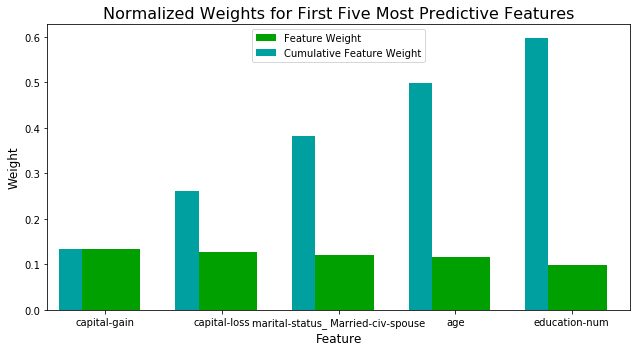


Model accuracy: 0.863018242123 , fscore:  0.73953385618

 top 10 important features


,importances,features
2,0.134675,capital-gain
3,0.126455,capital-loss
30,0.120483,marital-status_ Married-civ-spouse
0,0.11647,age
1,0.0992093,education-num
4,0.0723407,hours-per-week
38,0.0335374,occupation_ Exec-managerial
39,0.0257507,occupation_ Farming-fishing
54,0.0249573,relationship_ Wife
42,0.0237199,occupation_ Other-service


In [17]:
#  : Import a supervised learning model that has 'feature_importances_'
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier

#  : Train the supervised model on the training set 
model = GradientBoostingClassifier().fit(X_train, y_train)

#  : Extract the feature importances
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

# show scores
predictions = model.predict(X_test)
model_accuracy = accuracy_score(y_test, predictions)
model_fscore = fbeta_score(y_test, predictions, beta=0.5)
print "\nModel accuracy:", model_accuracy, ", fscore: ", model_fscore

# show most importance features
a = np.array(importances)
factors = pd.DataFrame(data = np.array([importances.astype(float), features.columns]).T,
                       columns = ['importances', 'features'])
factors = factors.sort_values('importances', ascending=False)

print "\n top 10 important features"
display(factors[:10])

### Discussion 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
_How do these five features compare to the five features we discussed in **Discussion 6**? If we were close to the same Response, how does this visualization confirm our thoughts? If we were not close, why do we think these features are more relevant?_

**Response:**

A) How do these five features compare to the five features we discussed in Discussion 6?

Features in Discussion 6 have two hits (age and marital status), one related (education-num), and two misses (capital gain and capital loss).

B) If we were close to the same Response, how does this visualization confirm our thoughts?

The importances given by ensemble classifier(GradientBoostingClassifier) is more accurate, as the trained model gives good accuracy & F-score and corresponding weights of feature importances.

C) If we were not close, why do we think these features are more relevant?

According to the model ranking - a) capital gain/loss (due to investments) are more important than education level /occupation/age, b) education-num(Number of education years) is more important than education level.I could reason that Capital gain(additional disposable income) can be utilized by respective person for donation purposes and similarly number of years of  education(education-num) means better expertise by virtue of more number of years of education, hence better high paying job

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model we found earlier, and train it on the same training set *with only the top five important features*. 

In [19]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print "Final Model trained on full data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))
print "\nFinal Model trained on reduced data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5))

Final Model trained on full data
------
Accuracy on testing data: 0.8494
F-score on testing data: 0.7008

Final Model trained on reduced data
------
Accuracy on testing data: 0.8356
F-score on testing data: 0.6690


### Discussion 8 - Effects of Feature Selection
*How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?*  
*If training time was a factor, would we consider using the reduced data as our training set?*

**Response:**
The scores of training top 5 features are slightly smaller than the full features, yet it only takes very less time for training and testing.

If time or computation power is of high priority we can reduced features for training 

